In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import scipy.stats
import sqlite3
import pandas as pd
import time
import datetime
import scipy.optimize as opt
import timeit
from collections import Counter

In [2]:
def run_query(query):
    conn = sqlite3.connect('data.db')
    cur = conn.cursor()
    df = pd.read_sql_query(query,conn)
    cur.close()
    return df

In [3]:
properties = run_query('SELECT * FROM properties')
properties.head()

,property_id,market,bedrooms,bathrooms,square_footage,year_built,onboard_date,offboard_date
0,39e8f56e421c,Nashville,4,2,2371,1969,2016-05-03,2016-08-04
1,fd2b1986594b,Atlanta,3,3,1863,1985,2016-05-03,2018-10-31
2,0a95b380ce50,Phoenix,4,2,1761,2016,2016-05-05,2020-08-06
3,2bbd0597eb52,Phoenix,3,2,1946,1970,2016-05-06,None
4,eccf3f60819d,Phoenix,3,2,1878,1995,2016-05-06,2017-03-04


In [4]:
def owned_props_on_date(properties,date):
    """Returns properties dataframe exluding entries not owned on date
    properties: given dataframe
    date: date of interest, datetime"""
    return properties[(pd.to_datetime(properties.onboard_date) <= date) \
    & ((pd.to_datetime(properties.offboard_date) >= date) \
        | properties.offboard_date.isnull())
    ]

In [5]:
#Day of first onboard
s_date = min(pd.to_datetime(properties.onboard_date))

#Day of most recent onboard
e_date = max(pd.to_datetime(properties.onboard_date))

#Range of dates between s_date and e_date with Daily spacing
date_range_D = pd.date_range(s_date,e_date,freq='D')

In [6]:
#Array of number of properties owned for each date in date_range_D
#NumProps_OD = np.array([len(owned_props_on_date(properties,date)) for date in date_range_D])
#np.save('NumProps_OD',NumProps_OD)
NumProps_OD = np.load('NumProps_OD.npy',allow_pickle=True)

In [7]:
def lin_model(x,a,b):
    """Linear fit model for lease renewal data
        a: fit parameter
        b: fit parameter
        x: absolute time"""
    return a*x + b

#to absolute time
epoch_drD = np.array([i.value for i in date_range_D])/(10**18)

x_data_0 = epoch_drD[-700:-1]
y_data_0 = NumProps_OD[-700:-1]

#results
theta_best_0, theta_cov_0 = opt.curve_fit(lin_model, x_data_0, y_data_0)

a_out_0 = theta_best_0[0]
b_out_0 = theta_best_0[1]

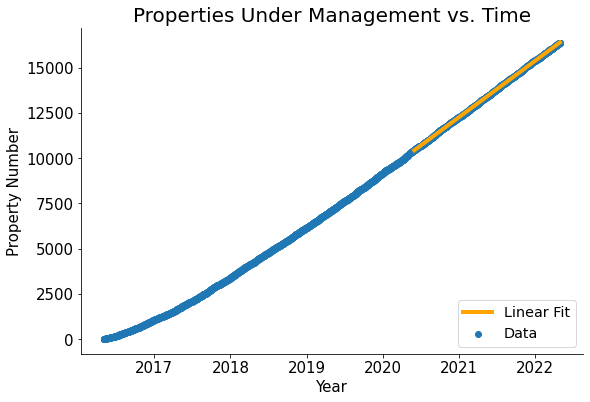

In [8]:
fig, ax = plt.subplots(figsize=(9,6));
plt.scatter(date_range_D,NumProps_OD,label='Data')

xticksposit = pd.Index.tolist(pd.date_range(s_date,e_date,freq='YS').strftime("%Y-%m-%d"))
xtickslabel = pd.Index.tolist(pd.date_range(s_date,e_date,freq='YS').strftime("%Y"))
plt.plot(date_range_D[-700:-1],lin_model(x_data_0,a_out_0,b_out_0),label='Linear Fit',color='orange',linewidth=4);

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(xticksposit)
ax.set_xticklabels(xtickslabel)
ax.xaxis.set_tick_params(rotation=0, labelsize=15)

plt.yticks(fontsize=15)
plt.xlabel('Year',size=15);
plt.ylabel('Property Number',size=15);
plt.title('Properties Under Management vs. Time',size=20);
plt.legend(loc=4,fontsize='x-large');
#plt.savefig('propsVtime.png')

In [9]:
lease_flows = run_query('SELECT * FROM lease_flows')
lease_flows.head()

,property_id,lease_flow_id,move_in_date,move_out_date
0,fd2b1986594b,e8237e1f3b761a,2016-07-05,2018-04-03
1,fd2b1986594b,f199bc03c4b75b,2018-06-05,None
2,0a95b380ce50,0a6ebfdfaf07a7,2016-07-05,None
3,2bbd0597eb52,65505023188e58,2016-07-02,2020-06-27
4,2bbd0597eb52,2538f02199d97e,2020-09-02,2021-09-01


In [10]:
def lease_flows_on_date(properties, lease_flows, date):
    """Returns lease_flows dataframe exluding entries corresponding to properties not owned on date
    properties: given dataframe
    lease_flows: given dataframe
    date: date of interest, datetime"""
    return lease_flows[lease_flows.property_id.isin(owned_props_on_date(properties,date).property_id)]

def occupied_on_date(properties, lease_flows, date):
    """Of those properties owned on date, returns the corresponding entries of lease_flows
    if the property is occupied on date.    
    properties: given dataframe
    lease_flows: given dataframe
    date: date of interest, datetime"""
    LF_OD = lease_flows_on_date(properties, lease_flows, date)
    return LF_OD[(pd.to_datetime(LF_OD.move_in_date) <= date) & \
            ((pd.to_datetime(LF_OD.move_out_date) > date) | \
            LF_OD.move_out_date.isnull())]

def vac_per_on_date(properties, lease_flows, date):
    """Returns percentage of properties owned on date that are vacant
    properties: given dataframe
    lease_flows: given dataframe
    date: date of interest, datetime"""
    NP_OD = len(owned_props_on_date(properties,date)) #Num Props owned on Date
    NO_OD = len(occupied_on_date(properties,lease_flows,date)) #Num occupied props on Date
    OccPer_OD = NO_OD/NP_OD #Occupancy Percentage on Date
    return 1 - OccPer_OD

In [11]:
#Array of vacancy percentage for each day in date_range_D
#VacPer_OD = np.array([vac_per_on_date(properties, lease_flows, date) for date in date_range_D])
#np.save('VacPer_OD',VacPer_OD)
VacPer_OD = np.load('VacPer_OD.npy',allow_pickle=True)

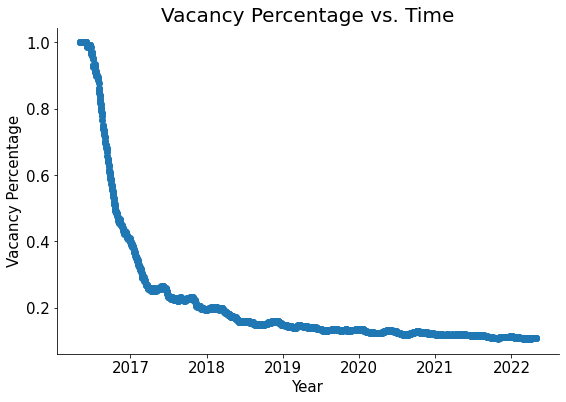

In [12]:
fig, ax = plt.subplots(figsize=(9,6));
plt.scatter(date_range_D,VacPer_OD,label='Data')

xticksposit = pd.Index.tolist(pd.date_range(s_date,e_date,freq='YS').strftime("%Y-%m-%d"))
xtickslabel = pd.Index.tolist(pd.date_range(s_date,e_date,freq='YS').strftime("%Y"))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(xticksposit)
ax.set_xticklabels(xtickslabel)
ax.xaxis.set_tick_params(rotation=0, labelsize=15)

plt.yticks(fontsize=15)
plt.xlabel('Year',size=15);
plt.ylabel('Vacancy Percentage',size=15);
plt.title('Vacancy Percentage vs. Time',size=20);
#plt.legend(loc=4,fontsize='x-large');
#plt.savefig('vacantVtime.png')

In [13]:
contracts = run_query('SELECT * FROM contracts')
contracts.head()

,property_id,lease_flow_id,contract_id,start_date,end_date
0,fd2b1986594b,e8237e1f3b761a,a77a7116a37e7d72,2016-07-05,2017-04-04
1,fd2b1986594b,e8237e1f3b761a,5c93e45f0496727c,2017-04-04,2018-04-03
2,fd2b1986594b,f199bc03c4b75b,2516f76d57be61d9,2018-06-05,2019-06-04
3,0a95b380ce50,0a6ebfdfaf07a7,04789bddb4ec1c97,2016-07-05,2017-07-04
4,0a95b380ce50,0a6ebfdfaf07a7,6dfb2816630945d9,2017-07-04,2018-07-03


In [14]:
def num_renews_OD(contracts,date):
    """Returns number of lease renewals on date
    contracts: given dataframe
    date: date of interest, datetime"""
    #Lease flow IDs that appear at least twice in contracts.lease_flow_id
    lf_ids = np.array([k for k,v in Counter(contracts.lease_flow_id).items() if v>1])
    #
    rel_contracts = contracts[(contracts.lease_flow_id.isin(lf_ids))&\
                              (contracts.start_date.isin(contracts.end_date))]
    #Initialize counter
    count = 0
    for lf_id in lf_ids:
        if (date in pd.to_datetime(np.array(rel_contracts[rel_contracts.lease_flow_id == lf_id].start_date))) and \
            (date in pd.to_datetime(np.array(rel_contracts[rel_contracts.lease_flow_id == lf_id].end_date))):
            count += 1
    return count

def num_expires_OD(contracts,date):
    """Returns number of contracts that expire on date
    contracts: given dataframe
    date: date of interest, datetime"""
    return len(contracts[pd.to_datetime(contracts.end_date) == date])

def perc_renews_OD(contracts,date):
    """Returns percentage of leases that are renewed on date
    contracts: given dataframe
    date: date of interest, datetime"""
    if num_expires_OD(contracts,date) > 0:
        return num_renews_OD(contracts,date)/num_expires_OD(contracts,date)
    else:
        return None

In [15]:
#RenewPer_OD_D = np.array([perc_renews_OD(contracts, date) for date in date_range_D])
#np.save('RenewPer_OD_D',RenewPer_OD_D)
RenewPer_OD_D = np.load('RenewPer_OD_D.npy', allow_pickle=True)

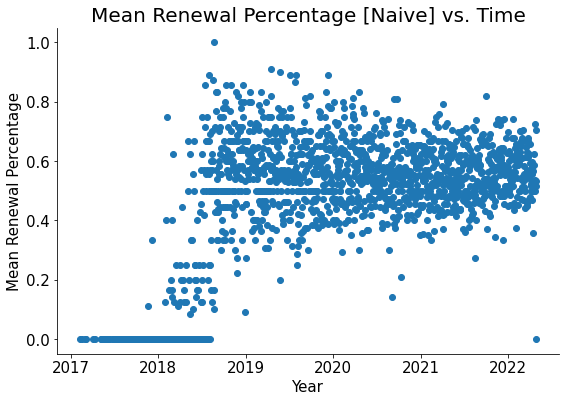

In [16]:
fig, ax = plt.subplots(figsize=(9,6));
plt.scatter(date_range_D,RenewPer_OD_D,label='Data')


xticksposit = pd.Index.tolist(pd.date_range(s_date,e_date,freq='YS').strftime("%Y-%m-%d"))
xtickslabel = pd.Index.tolist(pd.date_range(s_date,e_date,freq='YS').strftime("%Y"))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(xticksposit)
ax.set_xticklabels(xtickslabel)
ax.xaxis.set_tick_params(rotation=0, labelsize=15)

plt.yticks(fontsize=15)
plt.xlabel('Year',size=15);
plt.ylabel('Mean Renewal Percentage',size=15);
plt.title('Mean Renewal Percentage [Naive] vs. Time',size=20);
#plt.legend(loc=4,fontsize='x-large');
#plt.savefig('vacantVtime.png')

The above result is not aware (it is naive) of the number of times a lease has been already renewed. It's desirable to have a measure of the mean renewal percentage for first renewals, second renewals, and so on. 

In [17]:
#Avoid None for purpose of curve fit
rel_indices = np.array([i for i in np.arange(0,RenewPer_OD_D.shape[0]) if RenewPer_OD_D[i] is not None])

def logistic_model(x,x0,L,k):
    """Linear fit model for lease renewal data
        x0: fit parameter
        L: fit parameter
        k: fit parameter
        x: absolute time"""
    return L/(1+np.exp(-k*(x-x0)))

#to absolute time
epoch_drD = np.array([i.value for i in date_range_D])/(10**18)

x_data_1 = epoch_drD[rel_indices]
y_data_1 = RenewPer_OD_D[rel_indices]

#results
theta_best_1, theta_cov_1 = opt.curve_fit(logistic_model, x_data_1, y_data_1,method = "trf")

x0_out_1 = theta_best_1[0]
L_out_1 = theta_best_1[1]
k_out_1 = theta_best_1[2]

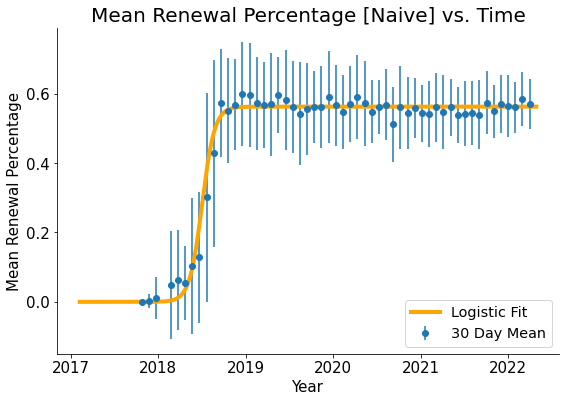

In [18]:
#For rolling average
RP_df = pd.DataFrame(RenewPer_OD_D,columns = ['Renew_Per'])
window = 30 #days

fig, ax = plt.subplots(figsize=(9,6));
#plt.scatter(date_range_D[::window],window_avg
plt.errorbar(date_range_D[::window], RP_df.rolling(window).mean()[::window].Renew_Per,\
             yerr=RP_df.rolling(window).std()[::window].Renew_Per, fmt="o",label='30 Day Mean')

plt.plot(date_range_D[rel_indices],logistic_model(x_data_1,x0_out_1,L_out_1,k_out_1),\
         label='Logistic Fit',color='orange',linewidth=4);

xticksposit = pd.Index.tolist(pd.date_range(s_date,e_date,freq='YS').strftime("%Y-%m-%d"))
xtickslabel = pd.Index.tolist(pd.date_range(s_date,e_date,freq='YS').strftime("%Y"))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(xticksposit)
ax.set_xticklabels(xtickslabel)
ax.xaxis.set_tick_params(rotation=0, labelsize=15)

plt.yticks(fontsize=15)
plt.xlabel('Year',size=15);
plt.ylabel('Mean Renewal Percentage',size=15);
plt.title('Mean Renewal Percentage [Naive] vs. Time',size=20);
plt.legend(loc=4,fontsize='x-large');
#plt.savefig('vacantVtime.png')

When computing the expected occupancy length, one might seek to average the time elapsed between move_in_dates and move_out_dates. However, the move_out_date is often Null. Furthermore, it appears that property "fd2b1986594b" was offboarded while a lease was active, meaning that its Null value for the move_out_date reflects a lack of information, rather than a continued lease. Thus, its appropriate to study the contractual start and end dates. 

In [19]:
#Create dataframe with unique lease_flow_ids and their lifetime
open_close = contracts[contracts.columns[0:2]].drop_duplicates().reset_index().drop(['index'],axis=1)

#open_dates = np.array([min(pd.to_datetime(contracts[contracts.lease_flow_id == lf_id].start_date))\
#          for lf_id in open_close.lease_flow_id])
#np.save('open_dates',open_dates)
open_dates = np.load('open_dates.npy',allow_pickle = True)

#close_dates = np.array([max(pd.to_datetime(contracts[contracts.lease_flow_id == lf_id].end_date))\
#          for lf_id in open_close.lease_flow_id])
#np.save('close_dates',close_dates)
close_dates = np.load('close_dates.npy',allow_pickle = True)

open_close['open_dates'] = open_dates
open_close['close_dates'] = close_dates
open_close['lifetimes'] = close_dates - open_dates

In [20]:
open_close.head()

,property_id,lease_flow_id,open_dates,close_dates,lifetimes
0,fd2b1986594b,e8237e1f3b761a,2016-07-05,2018-04-03,637 days
1,fd2b1986594b,f199bc03c4b75b,2018-06-05,2019-06-04,364 days
2,0a95b380ce50,0a6ebfdfaf07a7,2016-07-05,2021-06-29,1820 days
3,2bbd0597eb52,65505023188e58,2016-07-02,2020-06-27,1456 days
4,2bbd0597eb52,2538f02199d97e,2020-09-02,2021-09-01,364 days


In [21]:
def get_down_time(open_close,i):
    """returns time between open and close of successive contracts of same property
        i: indexes rows of open_close
        open_close: given data"""
    if open_close.property_id[i+1]==open_close.property_id[i]:
        return (open_close.open_dates[i+1]-open_close.close_dates[i]).value/((10**9)*86400)
    
open_close['downtimes'] = np.concatenate((\
                    np.array([get_down_time(open_close,i) for i in np.arange(0,open_close.shape[0]-1)]),\
                                          np.array([None])))

In [22]:
open_close.head()

,property_id,lease_flow_id,open_dates,close_dates,lifetimes,downtimes
0,fd2b1986594b,e8237e1f3b761a,2016-07-05,2018-04-03,637 days,63.0
1,fd2b1986594b,f199bc03c4b75b,2018-06-05,2019-06-04,364 days,None
2,0a95b380ce50,0a6ebfdfaf07a7,2016-07-05,2021-06-29,1820 days,None
3,2bbd0597eb52,65505023188e58,2016-07-02,2020-06-27,1456 days,67.0
4,2bbd0597eb52,2538f02199d97e,2020-09-02,2021-09-01,364 days,83.0


In [23]:
def get_wait_times_OD(open_close,date):
    """Returns all downtimes on date"""
    wait_times = np.array([dt for dt in open_close[open_close.close_dates == date].downtimes if dt is not None])
    if wait_times.size > 0:
        return wait_times
    
def get_avg_wait_times_OD(open_close,date):
    """Returns average of all downtimes on date"""
    wait_times = np.array([dt for dt in open_close[open_close.close_dates == date].downtimes if dt is not None])
    if wait_times.size > 0:
        return np.mean(wait_times)

In [24]:
avg_wait_times = np.array([get_avg_wait_times_OD(open_close,date) for date in \
                       np.sort(open_close.close_dates.unique())])

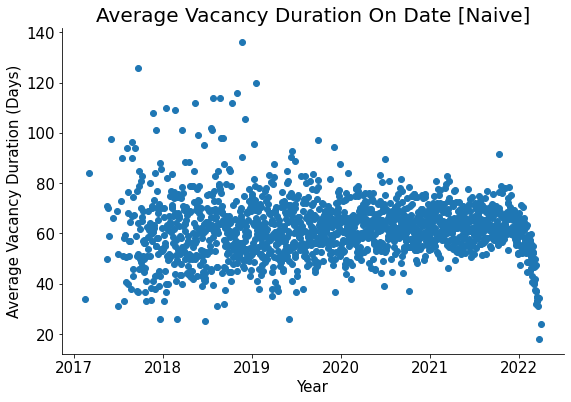

In [25]:
fig, ax = plt.subplots(figsize=(9,6));
plt.scatter(np.sort(open_close.close_dates.unique()),avg_wait_times)

xticksposit = pd.Index.tolist(pd.date_range(s_date,e_date,freq='YS').strftime("%Y-%m-%d"))
xtickslabel = pd.Index.tolist(pd.date_range(s_date,e_date,freq='YS').strftime("%Y"))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(xticksposit)
ax.set_xticklabels(xtickslabel,size=15)

plt.yticks(fontsize=15)
plt.xlabel('Year',size=15);
plt.ylabel('Average Vacancy Duration (Days)',size=15);
plt.title('Average Vacancy Duration On Date [Naive]',size=20);

Naive because we didn't allow for the currently vacant homes to have a chance at getting leased. Presumably, this would rectify the drop off for recent times. From here, it is plausible that the average vacancy duration is independent of time.

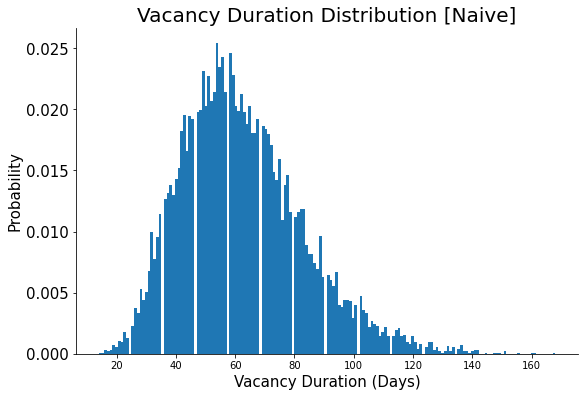

In [26]:
wait_times = np.array([dt for dt in open_close.downtimes if dt is not None])
bins = int(np.max(wait_times))

hist = np.histogram(wait_times, bins=bins)
hist_dist = scipy.stats.rv_histogram(hist)

fig, ax = plt.subplots(figsize=(9,6));
plt.hist(wait_times,bins=bins,zorder=0,density = True);

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#ax.set_xticks(xticksposit)
#ax.set_xticklabels(xtickslabel,size=15)

plt.yticks(fontsize=15)
plt.xlabel('Vacancy Duration (Days)',size=15);
plt.ylabel('Probability',size=15);
plt.title('Vacancy Duration Distribution [Naive]',size=20);

In [27]:
def get_lag_times(properties, open_close):
    """returns times between onboarding and first opened lease of successive contracts of all properties"""
    rel_df = properties[properties.property_id.isin(open_close.property_id)]
    rel_props = rel_df.property_id
    lag_times = np.array([(min(open_close[open_close.property_id == prop_id].open_dates\
    -pd.to_datetime(np.array(rel_df[rel_df.property_id == prop_id].onboard_date)[0]))).value/((10**9)*86400)\
          for prop_id in rel_props])
    return lag_times

In [28]:
#lag_times = get_lag_times(properties,open_close)
#np.save('lag_times',lag_times)
lag_times = np.load('lag_times.npy',allow_pickle = True)

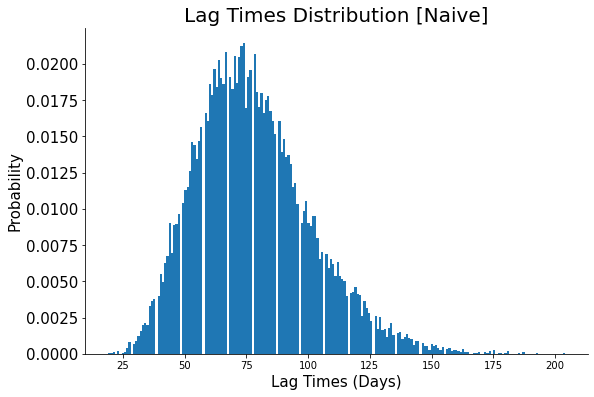

In [29]:
bins_lag = int(np.max(lag_times))

hist_lag = np.histogram(lag_times, bins=bins_lag)
hist_dist_lag = scipy.stats.rv_histogram(hist_lag)

fig, ax = plt.subplots(figsize=(9,6));
plt.hist(lag_times,bins=bins_lag,zorder=0,density = True);

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#ax.set_xticks(xticksposit)
#ax.set_xticklabels(xtickslabel,size=15)

plt.yticks(fontsize=15)
plt.xlabel('Lag Times (Days)',size=15);
plt.ylabel('Probability',size=15);
plt.title('Lag Times Distribution [Naive]',size=20);

In [30]:
def vacant_on_date(properties, lease_flows, open_close, date):
    """Of those properties owned on date that are vacant on date, returns time vacant   
    properties: given dataframe
    lease_flows: given dataframe
    date: date of interest no later than e_date, datetime"""
    OP_OD = owned_props_on_date(properties,date)
    vacant_ids_OD = OP_OD[\
            ~OP_OD.property_id.isin(occupied_on_date(properties,lease_flows,date).property_id)].property_id
    rel_df = open_close[(open_close.property_id.isin(vacant_ids_OD))&\
                     (open_close.open_dates < date) & (open_close.downtimes.isnull())].drop(columns \
                                                     = ['lease_flow_id','lifetimes', 'downtimes'])
    rel_df['time_vacant'] = date - rel_df.close_dates
    rel_df = rel_df.drop(columns = ['open_dates','close_dates']).reset_index().drop(columns = ['index'])
    rel_df['p_tom'] = hist_dist.pdf(np.array([wt.value/((10**9)*86400) for wt in rel_df.time_vacant]))
    
    new_df = owned_props_on_date(properties,date)[\
            ~(owned_props_on_date(properties,date).property_id.isin(\
                                occupied_on_date(properties,lease_flows,date).property_id))\
            & ~(owned_props_on_date(properties,date).property_id.isin(\
                                rel_df.property_id))].drop(\
                                        columns = ['market','bedrooms','bathrooms','square_footage',\
                                                  'year_built','offboard_date'])
    new_df['time_vacant'] = date - pd.to_datetime(new_df.onboard_date)
    new_df = new_df.reset_index()
    new_df = new_df.drop(columns = ['index','onboard_date'])
    new_df['p_tom'] = hist_dist_lag.pdf(np.array([wt.value/((10**9)*86400) for wt in new_df.time_vacant]))
    
    frames = [new_df,rel_df]
    output = pd.concat(frames,join="outer", ignore_index=True, sort=False)
    return output

In [31]:
vacant_on_date(properties, lease_flows, open_close, e_date).head()

,property_id,time_vacant,p_tom
0,ce679a7c8642,179 days,0.000000
1,9f92d1187049,148 days,0.000533
2,e74671a5274b,145 days,0.000888
3,3025fcd9f8fc,135 days,0.001302
4,9253e1d1b3db,132 days,0.001124


In [32]:
properties.head()

,property_id,market,bedrooms,bathrooms,square_footage,year_built,onboard_date,offboard_date
0,39e8f56e421c,Nashville,4,2,2371,1969,2016-05-03,2016-08-04
1,fd2b1986594b,Atlanta,3,3,1863,1985,2016-05-03,2018-10-31
2,0a95b380ce50,Phoenix,4,2,1761,2016,2016-05-05,2020-08-06
3,2bbd0597eb52,Phoenix,3,2,1946,1970,2016-05-06,None
4,eccf3f60819d,Phoenix,3,2,1878,1995,2016-05-06,2017-03-04


In [33]:
def onboard_on_date(properties,date):
    """Returns the number of properties onboarded on date"""
    return properties[pd.to_datetime(properties.onboard_date) == date].shape[0]

In [34]:
#onboard_number_OD = np.array([onboard_on_date(properties,date) for date in date_range_D])
#np.save('onboard_number_OD',onboard_number_OD)
onboard_number_OD = np.load('onboard_number_OD.npy',allow_pickle = True)

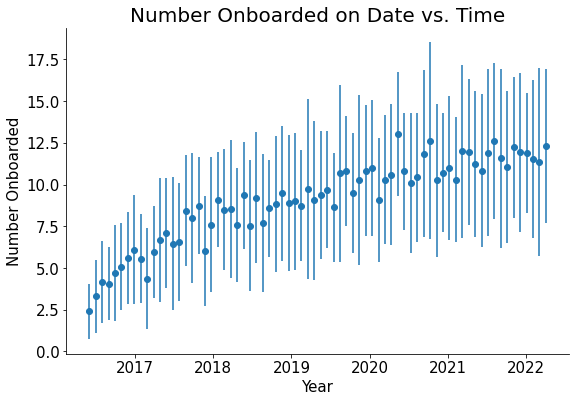

In [35]:
#For rolling average
OBN_df = pd.DataFrame(onboard_number_OD,columns = ['onboard_num'])
window = 30 #days

fig, ax = plt.subplots(figsize=(9,6));
#plt.scatter(date_range_D[::window],window_avg
plt.errorbar(date_range_D[::window], OBN_df.rolling(window).mean()[::window].onboard_num,\
             yerr=OBN_df.rolling(window).std()[::window].onboard_num, fmt="o",label='30 Day Mean')

xticksposit = pd.Index.tolist(pd.date_range(s_date,e_date,freq='YS').strftime("%Y-%m-%d"))
xtickslabel = pd.Index.tolist(pd.date_range(s_date,e_date,freq='YS').strftime("%Y"))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(xticksposit)
ax.set_xticklabels(xtickslabel)
ax.xaxis.set_tick_params(rotation=0, labelsize=15)

plt.yticks(fontsize=15)
plt.xlabel('Year',size=15);
plt.ylabel('Number Onboarded',size=15);
plt.title('Number Onboarded on Date vs. Time',size=20);
#plt.legend(loc=4,fontsize='x-large');
#plt.savefig('propsVtime.png')

In [36]:
C_OnBR = np.array([OBN_df.rolling(window).mean()[::window].onboard_num.reset_index().drop(\
                                    columns=['index']).iloc[-1]])[0][0]
C_OnBR

12.3

In [37]:
def offboard_on_date(properties,date):
    """Returns the number of properties offboarded on date"""
    return properties[pd.to_datetime(properties.offboard_date) == date].shape[0]

In [38]:
#offboard_number_OD = np.array([offboard_on_date(properties,date) for date in date_range_D])
#np.save('offboard_number_OD',offboard_number_OD)
offboard_number_OD = np.load('offboard_number_OD.npy',allow_pickle = True)

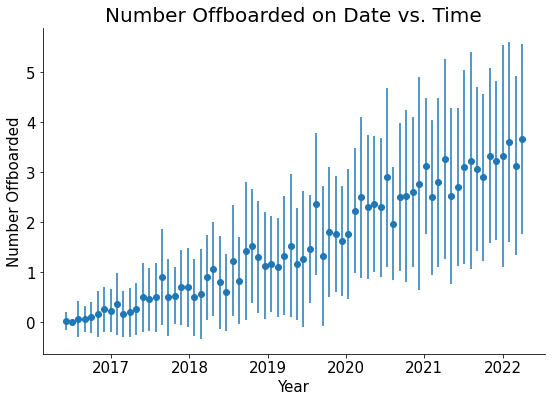

In [39]:
#For rolling average
OffBN_df = pd.DataFrame(offboard_number_OD,columns = ['offboard_num'])
window = 30 #days

fig, ax = plt.subplots(figsize=(9,6));
#plt.scatter(date_range_D[::window],window_avg
plt.errorbar(date_range_D[::window], OffBN_df.rolling(window).mean()[::window].offboard_num,\
             yerr=OffBN_df.rolling(window).std()[::window].offboard_num, fmt="o",label='30 Day Mean')

xticksposit = pd.Index.tolist(pd.date_range(s_date,e_date,freq='YS').strftime("%Y-%m-%d"))
xtickslabel = pd.Index.tolist(pd.date_range(s_date,e_date,freq='YS').strftime("%Y"))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(xticksposit)
ax.set_xticklabels(xtickslabel)
ax.xaxis.set_tick_params(rotation=0, labelsize=15)

plt.yticks(fontsize=15)
plt.xlabel('Year',size=15);
plt.ylabel('Number Offboarded',size=15);
plt.title('Number Offboarded on Date vs. Time',size=20);
#plt.legend(loc=4,fontsize='x-large');
#plt.savefig('propsVtime.png')

In [40]:
C_OffBR = np.array([OffBN_df.rolling(window).mean()[::window].offboard_num.reset_index().drop(\
                                    columns=['index']).iloc[-1]])[0][0]
C_OffBR

3.6666666666666665

In [41]:
C_OnBR - C_OffBR

8.633333333333335

In [42]:
a_out_0*(86400/(10**9))

8.542379716570466

In [43]:
def num_owned_expires_OD(contracts,date):
    """Returns number of contracts that expire on date and are still owned on date
    contracts: given dataframe
    date: date of interest, datetime"""
    rel_df = contracts[pd.to_datetime(contracts.end_date) == date]
    new_rel_df = rel_df[rel_df.property_id.isin(owned_props_on_date(properties,date).property_id)]
    return new_rel_df.shape[0]

In [44]:
def vacant_on_future_date(properties, contracts, lease_flows, open_close, future_date):
    "Predicts the number of vacant properties for future_date in may 2022"
    initial_vacancy_number = vacant_on_date(properties, lease_flows, open_close, e_date).shape[0]
    days_in_future = (future_date-e_date).value/((10**9)*86400)
    
    forward_dates = pd.date_range(pd.to_datetime('2022-05-01'),future_date, freq='D')
    n_e_l_OD = np.array([vacant_on_date(properties, lease_flows, open_close, date).p_tom.sum()\
                         for date in forward_dates])
    #renormalize to account for percentage of initial vacancies that get leased
    n_e_l_OD = np.concatenate((np.array([n_e_l_OD[0]]),\
                np.array([((initial_vacancy_number - n_e_l_OD[i])/initial_vacancy_number)*n_e_l_OD[i+1]\
          for i in np.arange(0,len(n_e_l_OD)-1)])))
    
    #Remaining initial vacancies
    propagated_IVC = initial_vacancy_number - np.sum(n_e_l_OD)

    #Approximate that no houses acquired in May are leased in May (See lag_time)
    acquired_prop_number = a_out_0*(86400/(10**9))*days_in_future
    
    #Known expiries in May modified by the renewal percentage
    expiries = np.sum(np.array([num_owned_expires_OD(contracts,date) for date in forward_dates]))*(1-L_out_1)
    
    return propagated_IVC + acquired_prop_number + expiries

In [45]:
#Date range for May
may = pd.date_range(pd.to_datetime('2022-05-01'),pd.to_datetime('2022-05-31'), freq='D')

#Predictions
#preds = np.array([vacant_on_future_date(properties, contracts, lease_flows, open_close, date) for date in may])
#np.save('preds',preds)
preds = np.load('preds.npy',allow_pickle = True)

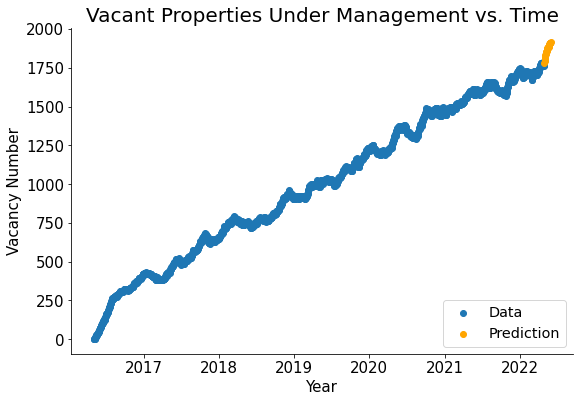

In [46]:
fig, ax = plt.subplots(figsize=(9,6));
plt.scatter(date_range_D,(VacPer_OD*NumProps_OD),label='Data')
plt.scatter(may,preds,label='Prediction',color='orange')

xticksposit = pd.Index.tolist(pd.date_range(s_date,e_date,freq='YS').strftime("%Y-%m-%d"))
xtickslabel = pd.Index.tolist(pd.date_range(s_date,e_date,freq='YS').strftime("%Y"))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(xticksposit)
ax.set_xticklabels(xtickslabel)
ax.xaxis.set_tick_params(rotation=0, labelsize=15)

plt.yticks(fontsize=15)
plt.xlabel('Year',size=15);
plt.ylabel('Vacancy Number',size=15);
plt.title('Vacant Properties Under Management vs. Time',size=20);
plt.legend(loc=4,fontsize='x-large');
#plt.savefig('propsVtime.png')

This looks plausible; assumptions should be revisited.